In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [2]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [32]:
# Restore session state i.e. all objects
# dill.load_session('session_states/session_state_het_amp.pkl')

# Save current session state
# dill.dump_session('session_states/session_state_het_amp.pkl')

### Amplitude diversity population coding model

As with the noise correlation simulations, we are using bell-shaped tuning curves uniformly distributed over the stimulus space.

The tuning curves have identical tuning width but (potentially) different amplitudes:

$$g_i(s)=A_i\exp\Bigg[-\frac{(s-\phi_i)^2}{2\omega^2}\Bigg]$$

In [3]:
def tuning_curve(pref_stim, stimulus, amplitude=1.0, tuning_width=0.5):
    return amplitude * exp( - (stimulus - pref_stim)**2 / (2 * tuning_width**2) )

def tuning_curve_2d(pref_stim, stim_1, stim_2, amplitude, tuning_width):
    return (tuning_curve(pref_stim, stim_1, amplitude, tuning_width)
            + tuning_curve(pref_stim, stim_2, amplitude, tuning_width))

def tuning_curve_theta(pref_stim, opening_angle, amplitude=1.0, tuning_width=0.5):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2, amplitude, tuning_width)

### Visualisation of amplitude diversity

Using the uniform distribution: $A_i \sim U(0.5, 1.5)$

In [4]:
def get_amplitudes_uniform(n_neurons):
    return np.random.rand(n_neurons) + 0.5

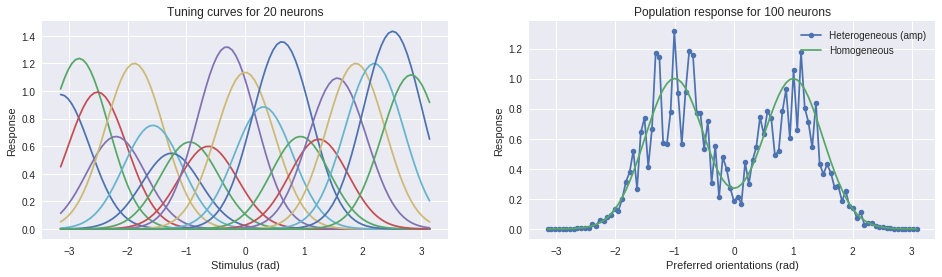

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
stim_space = np.linspace(-pi, pi, 100)

n_neurons = 20
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
amplitudes = get_amplitudes_uniform(n_neurons)

for i in range(n_neurons):
    plt.plot(stim_space, tuning_curve(pref_stims[i], stim_space, amplitudes[i]))

plt.xlabel('Stimulus (rad)')
plt.ylabel('Response')
plt.title('Tuning curves for {0} neurons'.format(n_neurons))

plt.subplot(122)
stim = 2.0

n_neurons = 100
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
amplitudes = get_amplitudes_uniform(n_neurons)

plt.plot(pref_stims, tuning_curve_theta(pref_stims, stim, amplitudes), '.-', mew=2, label='Heterogeneous (amp)')
plt.plot(pref_stims, tuning_curve_theta(pref_stims, stim), label='Homogeneous')

plt.legend()
plt.xlabel('Preferred orientations (rad)')
plt.ylabel('Response')
plt.title('Population response for {0} neurons'.format(n_neurons))

plt.rcParams['figure.figsize'] = (10, 5)

### Possible  amplitude distributions

In addition to a uniform distribution, we consider 3 types of distributions to sample the amplitude from:
* Truncated normal
* Lognormal
* Gamma

Truncated normal
Mean: 1.0
Std: 0.24664459814

Lognormal
Mean: 1.0317434075
Std: 0.262019072109

Gamma
Mean: 1.0
Std: 0.316227766017



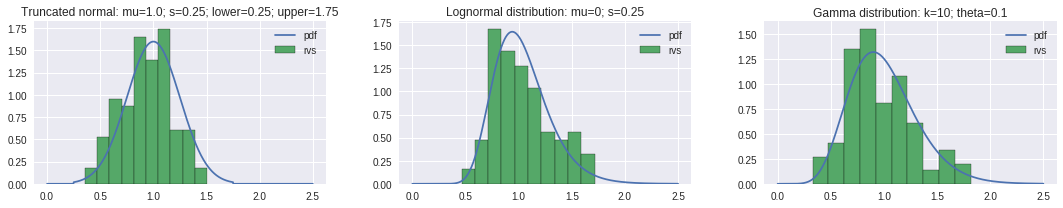

In [6]:
plt.rcParams['figure.figsize'] = (15, 3)

x_range = np.linspace(0, 2.5, 1000)

# Truncated normal
plt.subplot(131)
lower, upper = 0.25, 1.75
mu, sigma = 1.0, 0.25
a = (lower - mu) / sigma
b = (upper - mu) / sigma
X = stats.truncnorm(a, b, loc=mu, scale=sigma)

plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Truncated normal: mu=1.0; s=0.25; lower=0.25; upper=1.75')
plt.legend()

print 'Truncated normal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

# Lognormal
plt.subplot(132)
mu = 0
sigma = 0.25

X = stats.lognorm(sigma, scale=exp(mu))

plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Lognormal distribution: mu=0; s=0.25')
plt.legend()

print 'Lognormal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

# Gamma
plt.subplot(133)
shape = 10
scale = 0.1

X = stats.gamma(shape, scale=scale)

plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Gamma distribution: k=10; theta=0.1')
plt.legend()

print 'Gamma'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

### Noise model

The response of a neuron $i$ to a stimulus $\Theta$ is given by: $r_i = f_i(\Theta)  + v_i$ where $v_i = N(0, \sigma^2)$.

i.e. independent noise (equivalent to a diagonal covariance matrix for a vector of noise terms).

In [7]:
NOISE_SIGMA = 0.2

### Maximum Likelihood decoding

As before, the ML estimate corresponds to:
$$\hat{\theta} = \arg \max_{\theta}{\log{p(\mathbf{r} | \theta)}}$$

Again, we ignore terms independent of $\Theta$ resulting in:
$$\hat{\theta} = \arg \min_{\theta}{\Big\{ \sum_{i=1}^{N} {[r_i - f_i(\Theta)]}^2 \Big\}}$$

i.e. the ML estimate is equivalent to minimising the mean squared error between observed and expected response

In [8]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

In [14]:
def get_ML_ests(get_amplitudes, n_neurons=100, n_realisations=5000):
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))

    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    amplitudes = get_amplitudes(n_neurons)

    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]

        # Generate noisy pop. responses
        avg_pop_res = tuning_curve_theta(pref_stims, stim, amplitudes)
        pop_responses = avg_pop_res + np.random.normal(scale=NOISE_SIGMA, size=(n_realisations, n_neurons))

        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None], amplitudes)
        errors = np.sum((pop_responses-avg_tuning_curves[:,None])**2, axis=2)

        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]

        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()
        
    return [estimate_dists, biases, variances]

### Lognormal amplitude distribution

We start by sampling the amplitudes from the $\texttt{LogNorm}(\mu, \sigma)$ distribution with parameters:
* $\mu = 0$
* $\sigma = 0.25$

Lognormal
Mean: 1.0317434075
Std: 0.262019072109



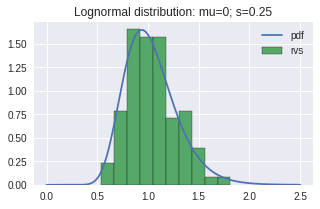

In [13]:
plt.rcParams['figure.figsize'] = (5, 3)

mu = 0
sigma = 0.25

X = stats.lognorm(sigma, scale=exp(mu))

x_range = np.linspace(0, 2.5, 1000)
plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Lognormal distribution: mu=0; s=0.25')
plt.legend()

print 'Lognormal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

plt.rcParams['figure.figsize'] = (10, 5)

In [46]:
def get_amplitudes_lognormal(n_neurons):
    mu, sigma = 0, 0.25
    return stats.lognorm.rvs(sigma, scale=exp(mu), size=n_neurons)

In [47]:
def get_amplitudes(n_neurons):
    return get_amplitudes_lognormal(n_neurons)

**We simulate the random amplitude model 10 times.**

In [48]:
n_sims = 10
ests_het_lognorm = [0 for _ in range(n_sims)]

for i in range(n_sims):
    ests_het_lognorm[i] = get_ML_ests(is_het=True)

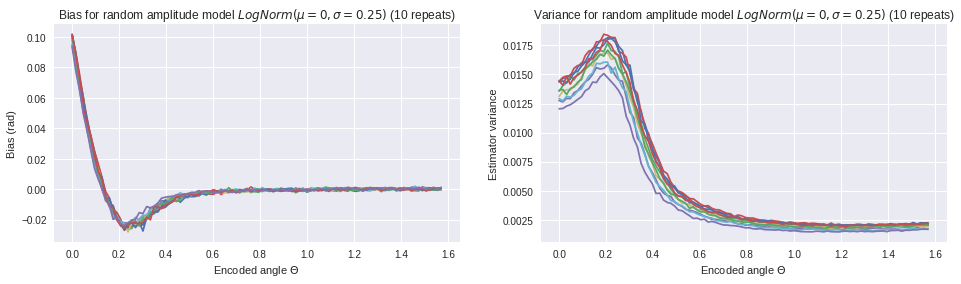

In [11]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
n_sims = 10
for i in range(n_sims):
    plt.plot(THETAS, ests_het_lognorm[i][1])

plt.title('Bias for random amplitude model $LogNorm(\mu=0, \sigma=0.25)$ (10 repeats)')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

plt.subplot(122)
n_sims = 10
for i in range(n_sims):
    plt.plot(THETAS, ests_het_lognorm[i][2])

plt.title('Variance for random amplitude model $LogNorm(\mu=0, \sigma=0.25)$ (10 repeats)')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')

plt.rcParams['figure.figsize'] = (10, 5)

**We then compute the average bias and variance curve & compare to homogeneous model.**

In [80]:
ests_hom = get_ML_ests()

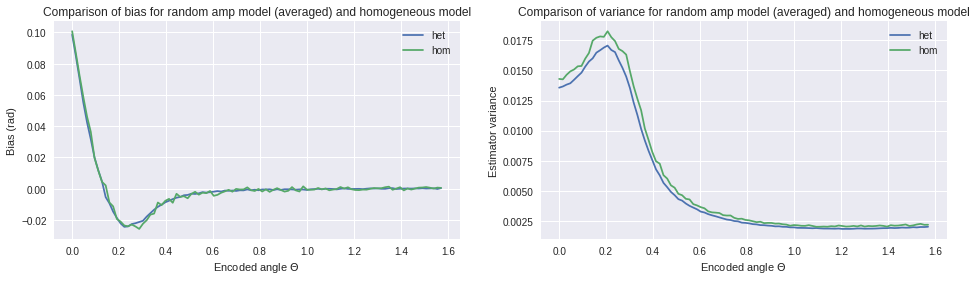

In [13]:
n_sims = 10
bias_all = [ests_het_lognorm[i][1] for i in range(n_sims)]
bias_avg = np.mean(bias_all, axis=0)

var_all = [ests_het_lognorm[i][2] for i in range(n_sims)]
var_avg = np.mean(var_all, axis=0)


plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)

plt.plot(THETAS, bias_avg, label='het')
plt.plot(THETAS, ests_hom[1], label='hom')

plt.title('Comparison of bias for random amp model (averaged) and homogeneous model')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.legend()

plt.subplot(122)

plt.plot(THETAS, var_avg, label='het')
plt.plot(THETAS, ests_hom[2], label='hom')

plt.title('Comparison of variance for random amp model (averaged) and homogeneous model')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.legend()

plt.rcParams['figure.figsize'] = (10, 5)

We observe little effect on the bias curve.


The variance is slightly reduced for the random amplitude model compared with the homogeneous model.

**Now we will compare the probabilities over candidate estimates for encoded angle $\Theta = 0$**

Function to compute probabilities from array of estimates

In [102]:
def get_histogram_probs(est_dist):
    weights = np.ones_like(est_dist)/float(len(est_dist))
    hist, bin_edges = np.histogram(est_dist, weights=weights, bins=CAND_ESTS)
    return hist

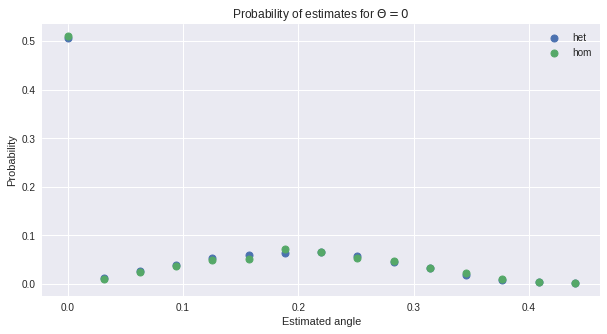

In [120]:
n_sims = 10
est_probs_all = [get_histogram_probs(ests_het_lognorm[i][0][0,:]) for i in range(n_sims)]
est_probs_avg = np.mean(est_probs_all, axis=0)

est_probs_hom = get_histogram_probs(ests_hom[0][0,:])

upper_lim = 15

plt.plot(CAND_ESTS[:upper_lim], est_probs_avg[:upper_lim], 'o', mew=1, label='het')
plt.plot(CAND_ESTS[:upper_lim], est_probs_hom[:upper_lim], 'o', mew=1, label='hom')

plt.title('Probability of estimates for $\Theta = 0$')
plt.xlabel('Estimated angle')
plt.ylabel('Probability')
plt.legend()

There is little difference between the two models

**Function to compute average estimate distribution, bias and variance across encoded angles by specifying number of times to repeat with different set of amplitudes (resampled each time)**

In [4]:
def get_ML_ests_het(get_amplitudes, n_repeats=10):
    ML_ests = [0 for _ in range(n_repeats)]
    
    for i in range(n_repeats):
        ML_ests[i] = get_ML_ests(get_amplitudes)
    
    bias_all = [ML_ests[i][1] for i in range(n_repeats)]
    bias_avg = np.mean(bias_all, axis=0)

    var_all = [ML_ests[i][2] for i in range(n_repeats)]
    var_avg = np.mean(var_all, axis=0)
    
    estimate_dists_avg = np.zeros((N_THETAS, N_CAND_ESTS-1))
    for stim_idx in range(N_THETAS):
        est_probs_all = [get_histogram_probs(ML_ests[i][0][stim_idx,:]) for i in range(n_repeats)]
        estimate_dists_avg[stim_idx,:] = np.mean(est_probs_all, axis=0)
    
    return [estimate_dists_avg, bias_avg, var_avg]

In order to better determine whether amplitude diversity affects the bias, we shall use a truncated normal distribution with different values of the variance.

Increasing the variance gives rise to greater amplitude diversity (since density of amplitudes at the tails is greater)

We use a truncated normal rather than continue using the lognormal since we can fix the mean with the truncated normal distribution and restrict the range of amplitudes.

### Truncated normal amplitude distribution

We use a distribution with range $[0.25, 1.75]$ and $\mu = 1.0$ and vary the standard deviation:
* $\sigma = 0.25$
* $\sigma = 0.5$
* $\sigma = 0.75$
* $\sigma = 1.0$

Truncated normal
Mean: 1.0
Std: 0.41692576817



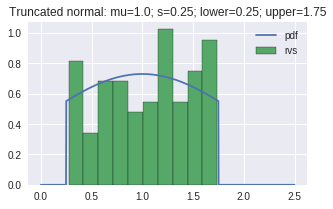

In [9]:
sigma = 1.0

x_range = np.linspace(0, 2.5, 1000)

lower, upper = 0.25, 1.75
mu = 1.0
a = (lower - mu) / sigma
b = (upper - mu) / sigma
X = stats.truncnorm(a, b, loc=mu, scale=sigma)

plt.rcParams['figure.figsize'] = (5, 3)

plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Truncated normal: mu=1.0; s=0.25; lower=0.25; upper=1.75')
plt.legend()

print 'Truncated normal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

plt.rcParams['figure.figsize'] = (10, 5)

In [41]:
def get_amplitudes_trunc_norm(n_neurons, sigma):
    lower, upper = 0.25, 1.75
    mu = 1.0
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    return stats.truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n_neurons)

In [50]:
x = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, 0.25)
ests_het_trunc_norm_025 = get_ML_ests_het(x)

In [14]:
x = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, 0.5)
ests_het_trunc_norm_050 = get_ML_ests_het(x)

In [15]:
x = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, 0.75)
ests_het_trunc_norm_075 = get_ML_ests_het(x)

In [16]:
x = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, 1.0)
ests_het_trunc_norm_100 = get_ML_ests_het(x)

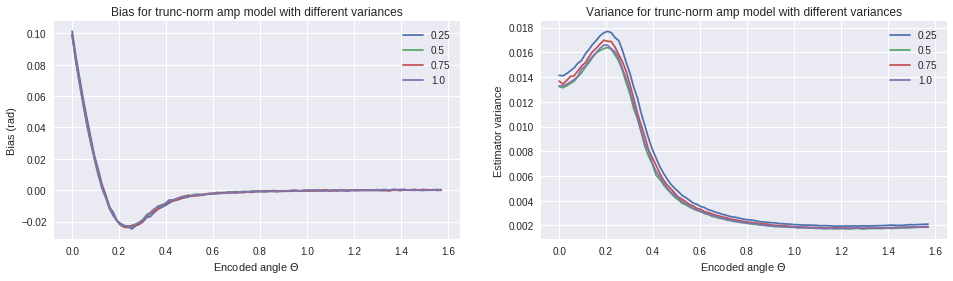

In [15]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)

plt.plot(THETAS, ests_het_trunc_norm_025[1], label='0.25')
plt.plot(THETAS, ests_het_trunc_norm_050[1], label='0.5')
plt.plot(THETAS, ests_het_trunc_norm_075[1], label='0.75')
plt.plot(THETAS, ests_het_trunc_norm_100[1], label='1.0')

plt.title('Bias for trunc-norm amp model with different variances')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.legend()

plt.subplot(122)

plt.plot(THETAS, ests_het_trunc_norm_025[2], label='0.25')
plt.plot(THETAS, ests_het_trunc_norm_050[2], label='0.5')
plt.plot(THETAS, ests_het_trunc_norm_075[2], label='0.75')
plt.plot(THETAS, ests_het_trunc_norm_100[2], label='1.0')

plt.title('Variance for trunc-norm amp model with different variances')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.legend()

plt.rcParams['figure.figsize'] = (10, 5)

Even with different values of the variance, the bias curve remains very similar.

We also looked at the estimate distribution at $\Theta=0$ and there was little difference.

In [52]:
print 'Bias at theta=0\n'

print 'sigma=0.25 : bias={0:.3f}'.format(ests_het_trunc_norm_025[1][0])
print 'sigma=0.50 : bias={0:.3f}'.format(ests_het_trunc_norm_050[1][0])
print 'sigma=0.75 : bias={0:.3f}'.format(ests_het_trunc_norm_075[1][0])
print 'sigma=1.00 : bias={0:.3f}'.format(ests_het_trunc_norm_100[1][0])

Bias at theta=0

sigma=0.25 : bias=0.101
sigma=0.50 : bias=0.099
sigma=0.75 : bias=0.099
sigma=1.00 : bias=0.099


Bias is marginally larger for $\sigma=0.25$ model.

We try further reducing the variance.

In [45]:
x = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, 0.10)
ests_het_trunc_norm_010 = get_ML_ests_het(x)

In [49]:
print 'sigma=0.10 : bias={0:.3f}'.format(ests_het_trunc_norm_010[1][0])

sigma=0.10 : bias=0.102


### Vary population size

We go back to the lognormal amplitude model and vary the number of neurons in the population.

We will compare the resulting bias curve with that of the homogeneous model.

**Function to get ML estimate only at $\Theta=0$**

In [77]:
def get_ML_ests_stim_0(get_amplitudes, n_neurons=100, n_realisations=5000):
    stim = 0.0
    estimate_dist = np.zeros(n_realisations)

    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    amplitudes = get_amplitudes(n_neurons)

    # Generate noisy pop. responses
    avg_pop_res = tuning_curve_theta(pref_stims, stim, amplitudes)
    pop_responses = avg_pop_res + np.random.normal(scale=NOISE_SIGMA, size=(n_realisations, n_neurons))

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None], amplitudes)
    errors = np.sum((pop_responses-avg_tuning_curves[:,None])**2, axis=2)

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return [estimate_dist, bias, variance]

**Function to compute average estimate distribution, bias and variance for $\Theta=0$ by specifying number of times to repeat with different set of amplitudes**

In [10]:
def get_ML_ests_het_stim_0(get_amplitudes, n_neurons=100, n_repeats=10, n_realisations=5000):
    ML_ests = [0 for _ in range(n_repeats)]
    
    for i in range(n_repeats):
        ML_ests[i] = get_ML_ests_stim_0(get_amplitudes, n_neurons, n_realisations)
    
    bias_all = [ML_ests[i][1] for i in range(n_repeats)]
    bias_avg = np.mean(bias_all)

    var_all = [ML_ests[i][2] for i in range(n_repeats)]
    var_avg = np.mean(var_all)
    
    est_probs_all = [get_histogram_probs(ML_ests[i][0]) for i in range(n_repeats)]
    estimate_dist_avg = np.mean(est_probs_all, axis=0)
    
    return [estimate_dist_avg, bias_avg, var_avg]

Get bias and variance for population sizes $N \in [1, 300]$ for:
* Random amplitude model: $\texttt{LogNorm}(\mu=0, \sigma=0.25)$
* Homogeneous model

In [4]:
amp_fun = get_amplitudes_lognormal

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_het_lognorm = np.zeros(len(n_neurons_arr))
variances_neurons_het_lognorm = np.zeros(len(n_neurons_arr))

for i in range(len(n_neurons_arr)):
    out = get_ML_ests_het_stim_0(amp_fun, n_neurons_arr[i])
    biases_neurons_het_lognorm[i] = out[1]
    variances_neurons_het_lognorm[i] = out[2]
    print i

In [5]:
amp_fun = lambda n_neurons: np.ones(n_neurons)

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_hom = np.zeros(len(n_neurons_arr))
variances_neurons_hom = np.zeros(len(n_neurons_arr))

for i in range(len(n_neurons_arr)):
    out = get_ML_ests_het_stim_0(amp_fun, n_neurons_arr[i], n_repeats=1)
    biases_neurons_hom[i] = out[1]
    variances_neurons_hom[i] = out[2]
    print i

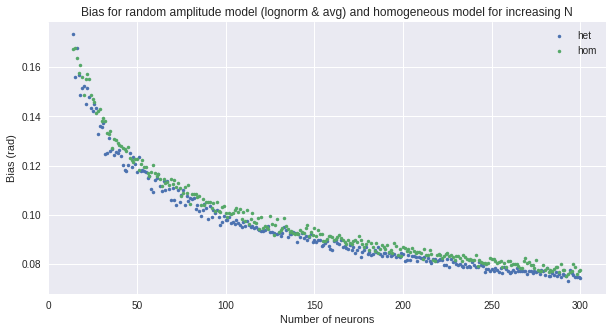

In [16]:
skip_idx = 13

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

plt.plot(n_neurons_arr[skip_idx:], biases_neurons_het_lognorm[skip_idx:], '.', label='het')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_hom[skip_idx:], '.', label='hom')

plt.legend()
plt.title('Bias for random amplitude model (lognorm & avg) and homogeneous model for increasing N')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

The bias for the heterogeneous curve appears slightly reduced across the range of population sizes compared with the homogeneous curve.

### Vary variance of truncated normal model

In [18]:
sigma_arr = np.linspace(0.01, 1.2, num=120)

ests_het_truncnorm_stim_0 = [0 for _ in range(len(sigma_arr))]

for i in range(len(sigma_arr)):
    amp_fun = lambda n_neurons: get_amplitudes_trunc_norm(n_neurons, sigma_arr[i])
    ests_het_truncnorm_stim_0[i] = get_ML_ests_het_stim_0(amp_fun, n_repeats=1000, n_realisations=1000)
    print i
    
dill.dump_session('session_states/session_state_het_amp.pkl')

In [24]:
hom_fun = lambda n_neurons: np.ones(n_neurons)
ests_hom_2 = get_ML_ests_het_stim_0(hom_fun, n_repeats=1000, n_realisations=1000)

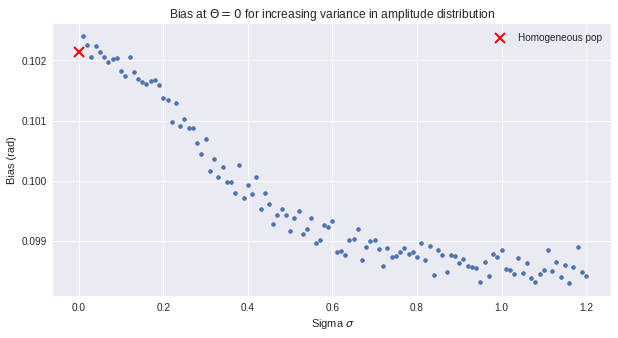

In [26]:
sigma_arr = np.linspace(0.01, 1.2, num=120)
biases = [ests_het_truncnorm_stim_0[i][1] for i in range(len(ests_het_truncnorm_stim_0))]

plt.plot(sigma_arr, biases, '.', mew=1)
plt.plot(0.0, ests_hom_2[1], 'x', color='r', mew=2, ms=10, label='Homogeneous pop')

plt.title('Bias at $\Theta=0$ for increasing variance in amplitude distribution')
plt.xlabel('Sigma $\sigma$')
plt.ylabel('Bias (rad)')
plt.legend()

This further confirms that amplitude diversity does reduce the bias (but only by small amount).

As in the tuning width investigation, we set `n_repeats` to 1000 and `n_realisations` to 1000.

In [30]:
biases = [ests_het_truncnorm_stim_0[i][1] for i in range(len(ests_het_truncnorm_stim_0))]

diff= ests_hom_2[1] - np.min(biases)

print '{0:.3f}'.format(diff)

0.004


The difference between the bias for the homogeneous population and the random amplitude model that gave rise to the minimum bias is just $0.004$.